# Zero Shot with CLIP on Test Dataset

- Got inspiration for finteuning here: https://github.com/sachinruk/blog/blob/master/_notebooks/2021-03-07-CLIP.ipynb
- Dataset: https://huggingface.co/datasets/AlekseyDorkin/extended_tweet_emojis/tree/main


In [10]:
# you might want to restart the kernel after installation is complete.
!pip install transformers evaluate docarray pillow datasets seaborn ipywidgets requests jupyter jupyter_client --upgrade --quiet

## 1. Getting Dataset

In [11]:
from datasets import load_dataset, Dataset

In [12]:
test_dataset = load_dataset("vincentclaes/emoji-predictor", split="test")
test_dataset

Using custom data configuration vincentclaes--emoji-predictor-84ee9ecf6ec78809
Reusing dataset parquet (/root/.cache/huggingface/datasets/vincentclaes___parquet/vincentclaes--emoji-predictor-84ee9ecf6ec78809/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['text', 'label'],
    num_rows: 3736
})

## 2. Get Emojis as Images

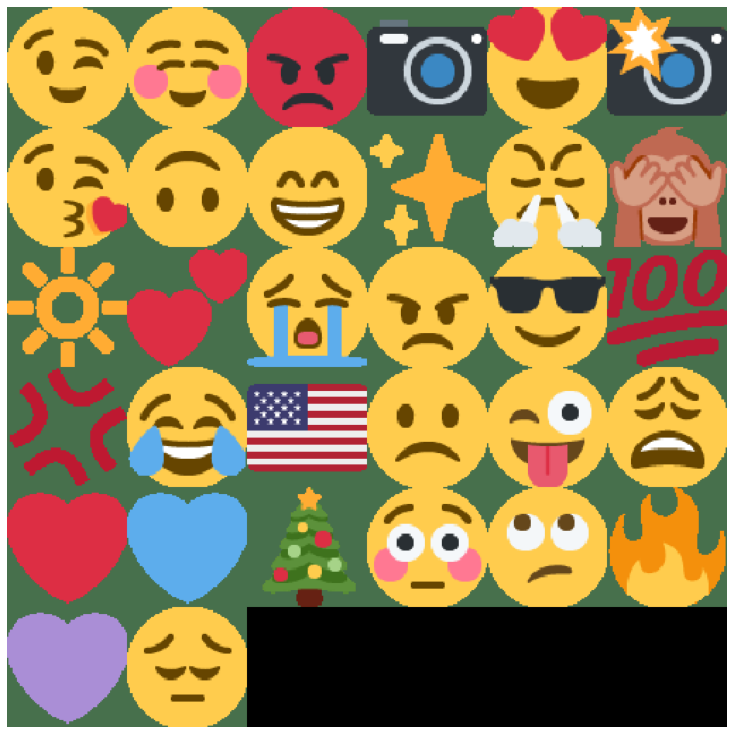

In [13]:
from docarray import DocumentArray

images = DocumentArray.from_files('emojis/*.png')
images.plot_image_sprites()

In [14]:
from PIL import Image

no_features = list(set(test_dataset["label"])) # these are the emoji's we use
emojis_as_images = [Image.open(f"emojis/{i}.png") for i in no_features]


## 3. Pass Test Dataset Throup CLIP

In [16]:
from transformers import CLIPProcessor, CLIPModel
import torch


In [18]:
predictions = []
references = []
SHARDS = 20
K=4
# not fully understanding this, but with torch.no_grad
# our GPU does not run out of memory.
with torch.no_grad():
    for i in range(SHARDS):
        chunk = test_dataset.shard(num_shards=SHARDS, index=i)
        chunk_text = chunk["text"]
        chunk_label = chunk["label"]
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        inputs = processor(text=chunk_text, images=emojis_as_images, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs.to("cuda"))
        # we want the probability for each emoji per sentence.
        logits_per_text = outputs.logits_per_text
        # we take the softmax to get the label probabilities
        probs = logits_per_text.softmax(dim=1)
        # top K number of options
        predictions_suggestions_for_chunk = [torch.topk(probs[0], K).indices.tolist() for prob in probs]
        # if the label is in the suggestions, take the label else take the first predicted one.
        predictions_for_chunk = [x if x in predictions_suggestions_for_chunk[i] else predictions_suggestions_for_chunk[i][0] for i,x in enumerate(chunk_label)]    
        predictions.extend(predictions_for_chunk)
        references.extend(chunk_label)
        print(f"total predictions so far: {len(predictions)}")
        torch.cuda.empty_cache()

total predictions so far: 187
total predictions so far: 374
total predictions so far: 561
total predictions so far: 748
total predictions so far: 935
total predictions so far: 1122
total predictions so far: 1309
total predictions so far: 1496
total predictions so far: 1683
total predictions so far: 1870
total predictions so far: 2057
total predictions so far: 2244
total predictions so far: 2431
total predictions so far: 2618
total predictions so far: 2805
total predictions so far: 2992
total predictions so far: 3178
total predictions so far: 3364
total predictions so far: 3550
total predictions so far: 3736


In [20]:
import evaluate
precision_metric = evaluate.load("precision")
# Micro-averaging will put more emphasis on the common classes in the data set. 
# Rare labels shouldn’t influence the overall precision metric heavily.
results = precision_metric.compute(references=references, predictions=predictions, average="micro")
print(results)

{'precision': 0.19700214132762311}


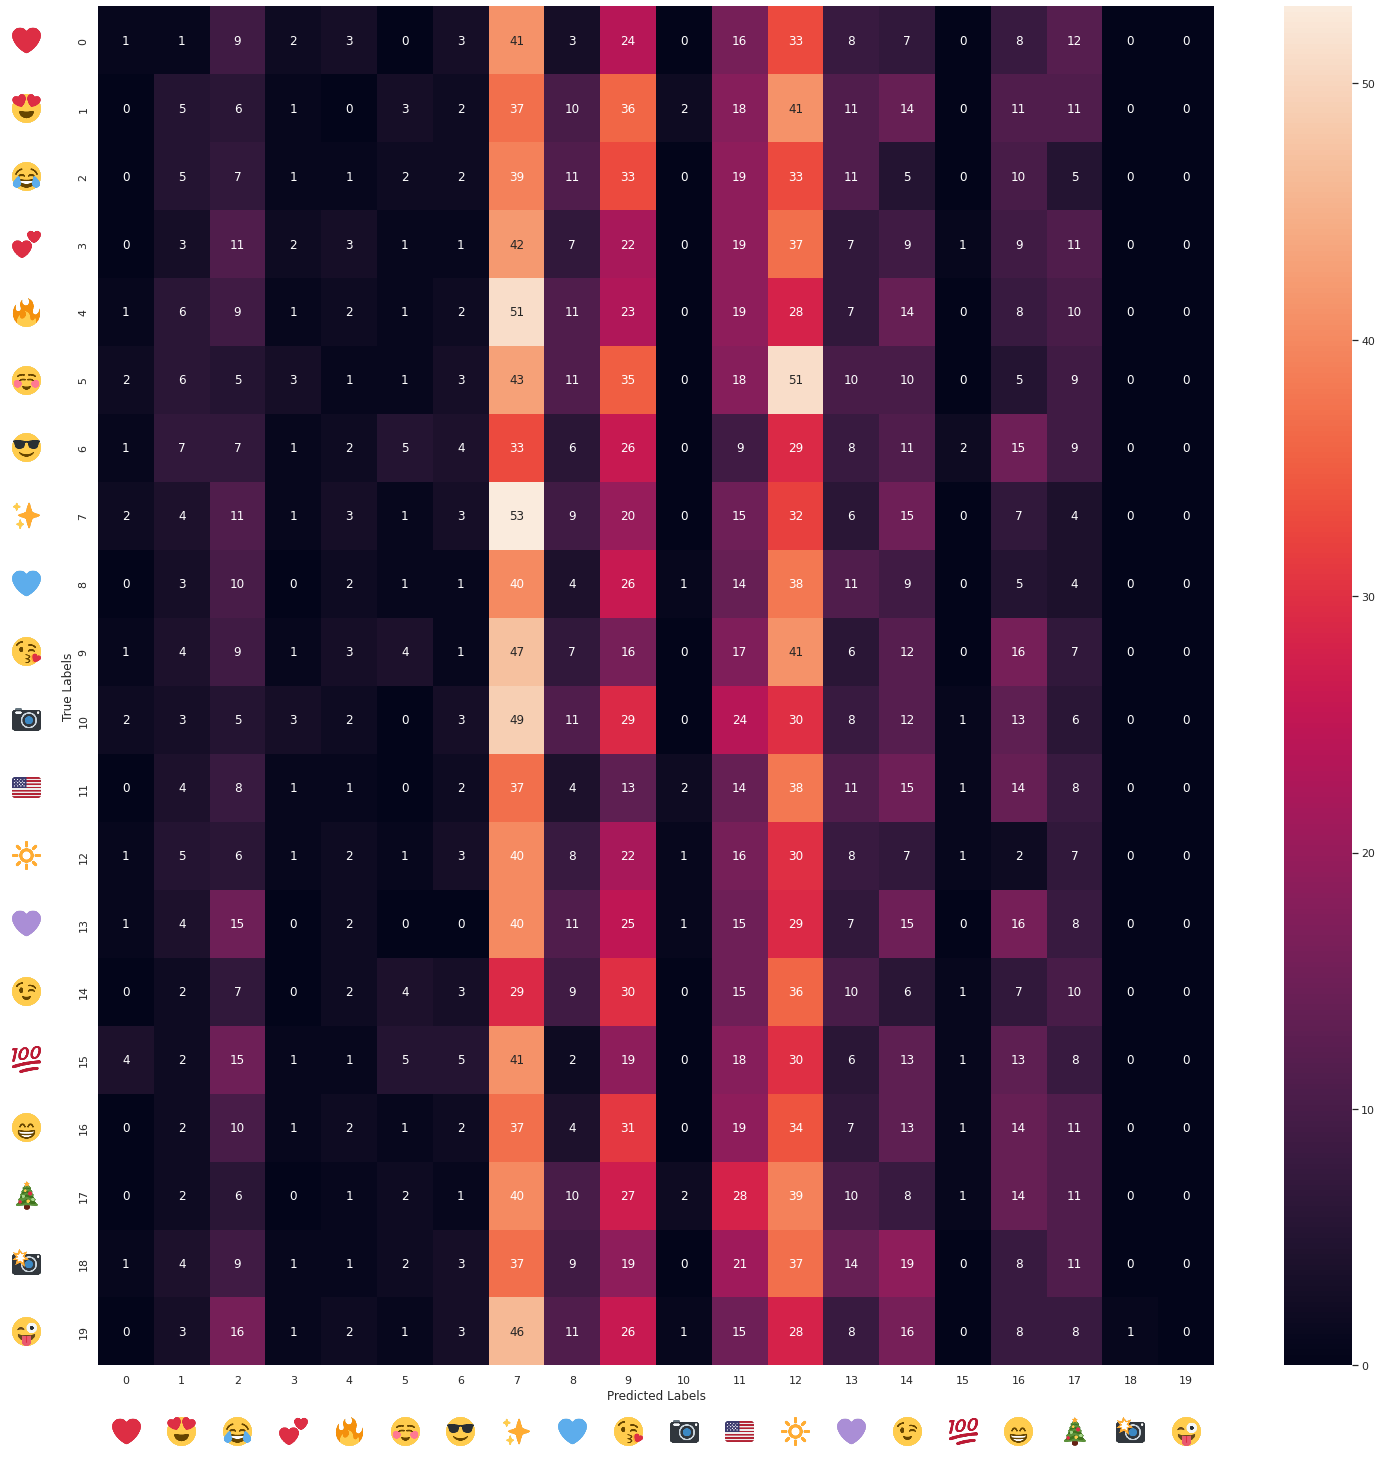

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

cm = confusion_matrix(test_dataset["label"], predictions)
# Normalise
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(rc={'figure.figsize':(25,25)})
heatmap = sns.heatmap(cm, annot=True)
heatmap.set(xlabel='Predicted Labels', ylabel='True Labels')

img = [plt.imread(f"emojis/{i}.png") for i in no_features]
tick_labels = heatmap.xaxis.get_ticklabels()
y_tick_labels = heatmap.yaxis.get_ticklabels()
for i,im in enumerate(img):
    ib = OffsetImage(im, zoom=.4)
    ib.image.axes = heatmap
    ab_x = AnnotationBbox(ib,
                    tick_labels[i].get_position(),
                    frameon=False,
                    box_alignment=(0.5, 50)
                    )
    ab_y = AnnotationBbox(ib,
                    y_tick_labels[i].get_position(),
                    frameon=False,
                    box_alignment=(3, 0.5)
                    )
    heatmap.add_artist(ab_x)
    heatmap.add_artist(ab_y)

plt.show(block=False)
